# Disaster or not Disaster Tweets

Written By: Alexander Wang

Date: August 20th, 2023

This project intends to build an NLP model to classify tweets on whether they refer to a real life disaster or not.

It utilizes 10k samples from the Natural Language Processing with Disaster Tweets Dataset from Kaggle (https://www.kaggle.com/competitions/nlp-getting-started/overview)

## Get Helper Functions

In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Import Data

In [4]:
import urllib.request
import zipfile

url = "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
filename = "nlp_getting_started.zip"
urllib.request.urlretrieve(url, filename)

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("nlp_getting_started.zip")
zip_ref.extractall()
zip_ref.close()

### Import Data - Visualized

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

## Preprocess Data

In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # Shuffle fraction 100%

### Split Data into Sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split Training Data into Train and Validation Sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # Use 10% of training data for validation split
                                                                            random_state=42)

### Text Vectorization (Tokenization)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [16]:
# These are the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # Max vocabulary number, will take the Top n most common words
                                    standardize="lower_and_strip_punctuation", # Remove unnecessary data that is not important to the purpose of the model
                                    split="whitespace", # delimiter
                                    ngrams=None, # How many words in a token (default = 1)
                                    output_mode="int", # Data type of the token
                                    output_sequence_length=None, # Will take longest sequence to be the length
                                    pad_to_max_tokens=True) # Will pad with 0s until max sequence length is reached

In [17]:
# Find the average number of tokens (words) in the training data
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15 # max length our sequences will be (how many words from a Tweet does our model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the vocabulary
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 leas common words: {bottom_5_words}")

Number of words: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 leas common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Embedding (Embedding Layer)

Parameters of the embedding layer:
1. input_dim = the size of our vocabulary
2. output_dim = the size of our output embedding vector
3. input_length = length of the sequence being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length
                            )
embedding

### Preprocess Data - Visualized

In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class are there?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
#News Bin Laden family plane crashed after 'avoiding microlight and landing too far down runway' http://t.co/x9MDHocpda

---

Target: 1 (real disaster)
Text:
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...

---

Target: 0 (not real disaster)
Text:
Building the perfect tracklist to life leave the streets ablaze

---

Target: 1 (real disaster)
Text:
@selmoooooo @_edvinnn @imTariik @dzafic_haris selmo u not catching flames from me  im just gonna be witnessing the slaughter

---

Target: 0 (not real disaster)
Text:
I'm battling monsters I'm pulling you out of the burning buildings and you say I'll give you anything but you never come through.

---



In [13]:
# Check the lengths of our splits
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n{random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original Text:
1.94 earthquake occurred 5km S of Volcano Hawaii at 01:04 UTC! #earthquake #Volcano http://t.co/auf4J4Owj1        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  290, 1068, 2205,  236,    6,  524, 1665,   17, 4193, 1931,
         290,  524,    1,    0]], dtype=int64)>

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}")
print(f"\n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size first)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/Q0X7e84R4e


Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 5.7339668e-05, -7.8864805e-03, -8.4780529e-04, ...,
          2.3619700e-02,  2.1098126e-02, -1.9919861e-02],
        [ 1.9246999e-02,  1.6769413e-02, -2.6385859e-04, ...,
          3.7323330e-02,  3.9960671e-02, -2.9433632e-02],
        [-3.8626540e-02,  3.1560548e-03, -1.7068136e-02, ...,
          8.4113479e-03, -1.5483130e-02, -2.4541467e-04],
        ...,
        [-4.2984858e-03, -2.0683313e-02, -1.6953599e-02, ...,
         -1.6439818e-02,  3.7094031e-02, -3.6875021e-02],
        [ 1.8096790e-03, -2.2562576e-02,  1.7220620e-02, ...,
          3.5259631e-02,  3.3818219e-02,  3.9822832e-03],
        [ 1.8065538e-02,  3.6106620e-02,  3.0682329e-02, ...,
         -3.0567909e-02,  9.5974803e-03,  1.5388679e-02]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 5.73396683e-05, -7.88648054e-03, -8.47805291e-04, -6.73151016e-03,
         3.87971438e-02,  3.96238603e-02, -2.37920769e-02, -4.47144881e-02,
         1.93371885e-02,  1.27013065e-02,  1.55675672e-02,  2.60746479e-03,
        -3.79918106e-02,  4.98422422e-02,  1.17323175e-02, -2.93196365e-03,
         1.48347951e-02,  1.39836222e-03,  4.72952761e-02,  2.07565688e-02,
        -2.74412874e-02,  7.92215019e-03, -3.37081105e-02, -4.79017757e-02,
        -4.04608734e-02,  3.85698788e-02,  3.85418795e-02,  1.56568177e-02,
        -1.73413157e-02, -2.74437070e-02, -3.34809907e-02,  3.14064063e-02,
        -1.80081949e-02,  4.11372222e-02, -3.17788273e-02,  4.69740666e-02,
         1.06505528e-02,  1.09123103e-02, -2.24240776e-02, -4.37329784e-02,
         1.39478333e-02,  3.19458954e-02,  4.10428084e-02,  4.81687225e-02,
        -2.55432371e-02,  6.37974590e-03, -4.45573218e-02, -1.85189620e-02,
         2.70070694e-02,  6.44506142e-0

## Function: Evaluate Predictions/Calculate Metrics

In [29]:
# Function to evaluate accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates metrics for binary classification model
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)*100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

## Model 0: Multinomial Naive Bayes (baseline)

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

We'll use sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words into numbers

### Create Model

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluate Model

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: Feed-forward neural network (Dense model)

### Create Model

In [31]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each vector to one token
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230817-171255
Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6124 - accuracy: 0.6907 - val_loss: 0.5346 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4422 - accuracy: 0.8190 - val_loss: 0.4704 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3475 - accuracy: 0.8581 - val_loss: 0.4588 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2849 - accuracy: 0.8889 - val_loss: 0.4606 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2384 - accuracy: 0.9102 - val_loss: 0.4821 - val_accuracy: 0.7887


### Evaluate Model

In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4821 - accuracy: 0.7887


[0.4821254014968872, 0.7887139320373535]

In [37]:
# Make some predictions and evaluate them
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [39]:
# Convert model prediction probabilities into label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [40]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7953441303708004,
 'recall': 0.7887139107611548,
 'f1': 0.7852145092095362}

### Model 1 - Visualized

In [ ]:
# Look at predictions
model_1_pred_probs[:10]

array([[0.31942767],
       [0.69542164],
       [0.99750984],
       [0.11516048],
       [0.12425315],
       [0.93559253],
       [0.91123885],
       [0.9937827 ],
       [0.9609585 ],
       [0.2799701 ]], dtype=float32)

## Model 2: LSTM (RNN)

### Create Model

In [46]:
# Create an LSTM Model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # use multiples of 8 to speed up training
# print(x.shape) # when you're stacking RNN cells together you need to return sequences = True
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230817-171303
Epoch 1/5
215/215 [==============================] - 4s 10ms/step - loss: 0.2231 - accuracy: 0.9186 - val_loss: 0.5532 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1544 - accuracy: 0.9415 - val_loss: 0.6665 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1264 - accuracy: 0.9505 - val_loss: 0.7122 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1058 - accuracy: 0.9583 - val_loss: 0.9220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0844 - accuracy: 0.9680 - val_loss: 0.9515 - val_accuracy: 0.7782


### Evaluate Model

In [50]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[6.5548932e-03],
       [6.1689508e-01],
       [9.9978989e-01],
       [3.6965031e-02],
       [5.2432891e-04],
       [9.9938715e-01],
       [8.8216001e-01],
       [9.9986124e-01],
       [9.9978215e-01],
       [4.9197808e-01]], dtype=float32)

In [51]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'precision': 0.7788175714535679,
 'recall': 0.7782152230971129,
 'f1': 0.7768408365477965}

## Model 3: GRU (RNN)

### Create Model

In [53]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x) # if you want to stack recurrent layers on top of each other you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230817-171314
Epoch 1/5
215/215 [==============================] - 3s 9ms/step - loss: 0.1557 - accuracy: 0.9368 - val_loss: 0.8798 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0838 - accuracy: 0.9693 - val_loss: 0.7849 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0772 - accuracy: 0.9702 - val_loss: 0.8091 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0619 - accuracy: 0.9749 - val_loss: 1.0713 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0550 - accuracy: 0.9772 - val_loss: 1.1742 - val_accuracy: 0.7703


### Evaluate Model

In [57]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)

In [58]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [59]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels,
                                    model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701208199177533,
 'recall': 0.7703412073490814,
 'f1': 0.7695203715374298}

## Model 4: Bidirectional RNN

### Create Model

In [60]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [62]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230817-171323
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.1002 - accuracy: 0.9708 - val_loss: 0.9960 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0561 - accuracy: 0.9752 - val_loss: 1.2999 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0440 - accuracy: 0.9810 - val_loss: 1.4107 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0458 - accuracy: 0.9793 - val_loss: 1.2057 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0413 - accuracy: 0.9800 - val_loss: 1.4789 - val_accuracy: 0.7651


### Evaluate Model

In [64]:
# Make the predictions
model_4_pred_probs = model_4.predict(val_sentences)

In [65]:
# Convert to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate results
model_4_results = calculate_results(val_labels,
                                    model_4_preds)
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7666862986020204,
 'recall': 0.7650918635170604,
 'f1': 0.7628949062414964}

## Model 5: Conv1D (CNN)

### Create Model

In [72]:
# Create a 1-D CNN layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [73]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Conv1D")])

Saving TensorBoard log files to: model_logs/model_5_Conv1D/20230817-171356
Epoch 1/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1277 - accuracy: 0.9545 - val_loss: 0.9297 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0752 - accuracy: 0.9729 - val_loss: 1.0524 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0592 - accuracy: 0.9772 - val_loss: 1.1722 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0554 - accuracy: 0.9756 - val_loss: 1.3166 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0508 - accuracy: 0.9784 - val_loss: 1.2607 - val_accuracy: 0.7572


### Evaluate Model

In [74]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.16310745e-01],
       [8.25732172e-01],
       [9.99884367e-01],
       [5.46054170e-02],
       [3.20239934e-07],
       [9.99344766e-01],
       [9.85822737e-01],
       [9.99987841e-01],
       [9.99999166e-01],
       [9.36842144e-01]], dtype=float32)

In [75]:
# Convert to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [76]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels,
                                    model_5_preds)
model_5_results

{'accuracy': 75.7217847769029,
 'precision': 0.7572094843193692,
 'recall': 0.7572178477690289,
 'f1': 0.7559398344614434}

### Model 5 - Visualized

In [68]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers

embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="same")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through Conv1D layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important features"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

## Model 6: TF Hub Pretrained USE (100% Data)

Let's use Tensorflow Hub's Universal Sentence Encoder

### Create Model

In [ ]:
import tensorflow_hub as hub

In [79]:
# Create a Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [80]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [81]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20230817-171415
Epoch 1/5
215/215 [==============================] - 5s 15ms/step - loss: 0.5050 - accuracy: 0.7878 - val_loss: 0.4493 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4145 - accuracy: 0.8135 - val_loss: 0.4393 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4011 - accuracy: 0.8232 - val_loss: 0.4361 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3928 - accuracy: 0.8260 - val_loss: 0.4286 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3856 - accuracy: 0.8310 - val_loss: 0.4252 - val_accuracy: 0.8189


### Evaluate Model

In [82]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17693938],
       [0.78890705],
       [0.98894125],
       [0.22140625],
       [0.72173214],
       [0.74509835],
       [0.9844577 ],
       [0.9838181 ],
       [0.9462686 ],
       [0.08674148]], dtype=float32)

In [83]:
# Convert to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [84]:
# Calculate results
model_6_results = calculate_results(val_labels,
                                    model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8203089036947304,
 'recall': 0.8188976377952756,
 'f1': 0.8177314483416845}

In [85]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 6 - Visualized

In [77]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [78]:
embed_samples.shape

TensorShape([2, 512])

## Model 7: TF Hub Pretrained USE (10% Data)

### Make Data Subset

In [ ]:
# Making a dataset
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [88]:
import numpy as np

# Check the number of targets in our subset of data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [89]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

### Create Model

In [90]:
# We want to change the name though so remake it
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [91]:
# Fit the model to 10% of data
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_USE_correct")])

Saving TensorBoard log files to: model_logs/model_7_USE_correct/20230817-171432
Epoch 1/5
22/22 [==============================] - 2s 42ms/step - loss: 0.6673 - accuracy: 0.6803 - val_loss: 0.6479 - val_accuracy: 0.7113
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5976 - accuracy: 0.8000 - val_loss: 0.5911 - val_accuracy: 0.7638
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5247 - accuracy: 0.8175 - val_loss: 0.5410 - val_accuracy: 0.7703
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4666 - accuracy: 0.8190 - val_loss: 0.5051 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4243 - accuracy: 0.8321 - val_loss: 0.4940 - val_accuracy: 0.7782


### Evaluate Model

In [92]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.20442435],
       [0.5790032 ],
       [0.8860129 ],
       [0.3893892 ],
       [0.5530557 ],
       [0.7090674 ],
       [0.8605538 ],
       [0.8009282 ],
       [0.8428636 ],
       [0.15864077]], dtype=float32)

In [93]:
# Turn into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [94]:
# Calculate the results
model_7_results = calculate_results(val_labels,
                                    model_7_preds)
model_7_results

{'accuracy': 77.82152230971128,
 'precision': 0.7790000273393579,
 'recall': 0.7782152230971129,
 'f1': 0.776732468906972}

In [95]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8203089036947304,
 'recall': 0.8188976377952756,
 'f1': 0.8177314483416845}

## All Model Results - Visualized

### Performance Metrics

In [96]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_use": model_6_results,
                                  "7_use_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.795344,0.788714,0.785215
2_lstm,77.821522,0.778818,0.778215,0.776841
3_gru,77.034121,0.770121,0.770341,0.769520
4_bidirectional,76.509186,0.766686,0.765092,0.762895
5_conv1d,75.721785,0.757209,0.757218,0.755940
6_use,81.889764,0.820309,0.818898,0.817731
7_use_10_percent,77.821522,0.779000,0.778215,0.776732


In [97]:
# Reduce the accuracy to the same scale as the other metrics
all_model_results["accuracy"] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.795344,0.788714,0.785215
2_lstm,0.778215,0.778818,0.778215,0.776841
3_gru,0.770341,0.770121,0.770341,0.769520
4_bidirectional,0.765092,0.766686,0.765092,0.762895
5_conv1d,0.757218,0.757209,0.757218,0.755940
6_use,0.818898,0.820309,0.818898,0.817731
7_use_10_percent,0.778215,0.779000,0.778215,0.776732


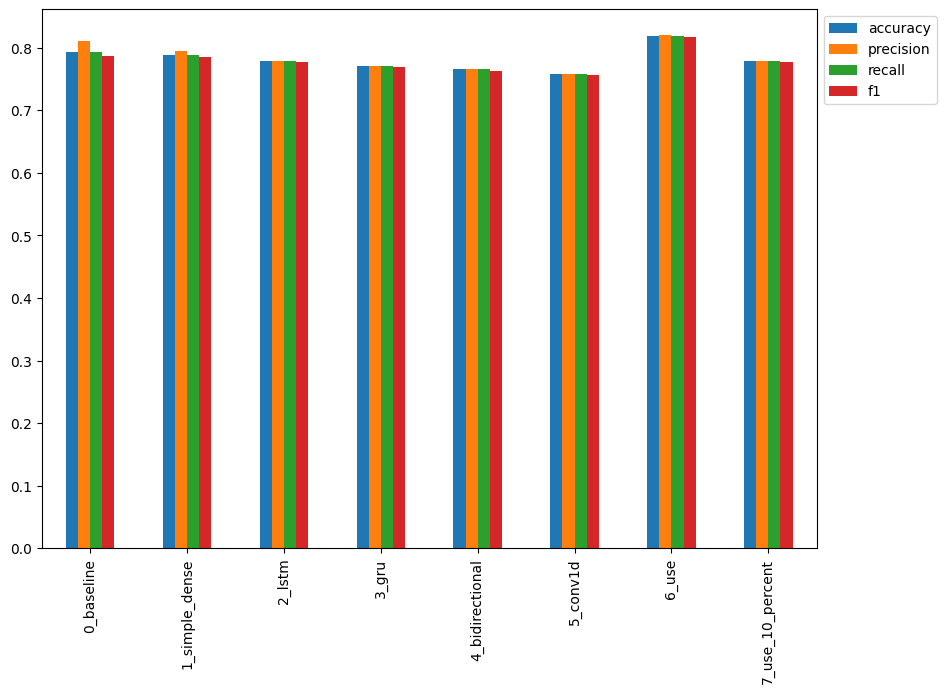

In [98]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

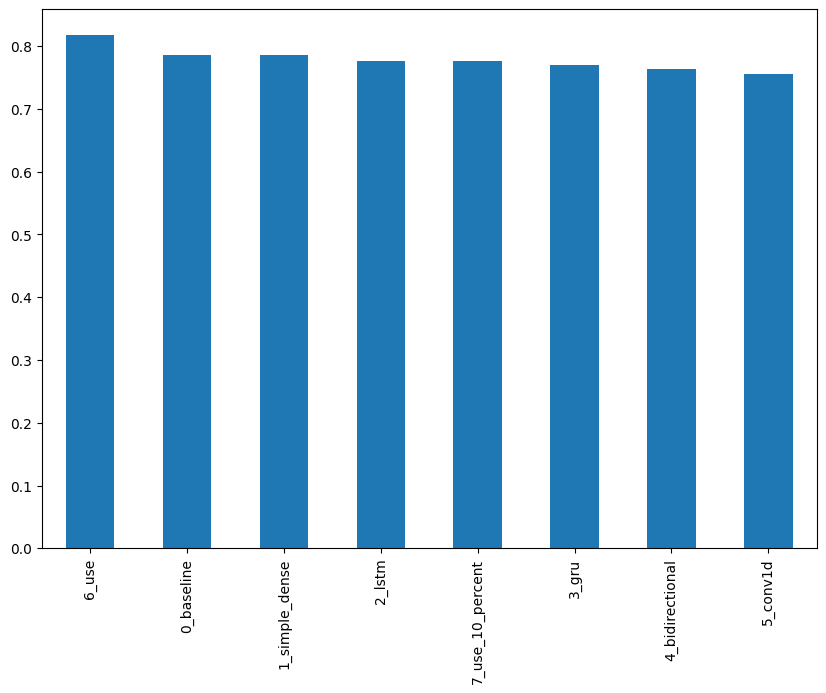

In [99]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

### Evaluate Inference Time

In [109]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8203089036947304,
 'recall': 0.8188976377952756,
 'f1': 0.8177314483416845}

In [111]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [112]:
# let's make a function to measure time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.
    """
    
    start_time = time.perf_counter() # get start time
    model.predict(samples)
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

In [113]:
# Calculate TF Hub time
model_6_total_time, model_6_time_per_pred = pred_timer(model_6,
                                                       val_sentences)
model_6_total_time, model_6_time_per_pred

(0.429960299981758, 0.0005642523621807848)

In [114]:
# Calculate baseline model time
baseline_total_time, baseline_time_per_pred = pred_timer(model_0,
                                                         val_sentences)
baseline_total_time, baseline_time_per_pred

(0.010297700064256787, 1.3514042079077149e-05)

Text(0.5, 0, 'Time per prediction')

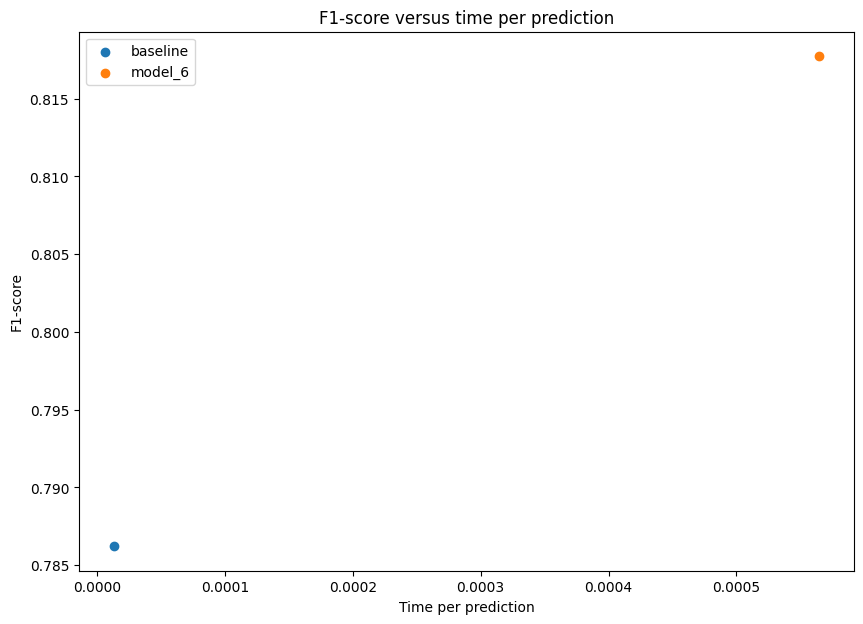

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="model_6")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.ylabel("F1-score")
plt.xlabel("Time per prediction")

## Save and Load Model

In [ ]:
# Save TF Hub model to H5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub layer (required for HDF5 format)
import tensorflow_hub as hub

loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer}) # You need to load models with custom layers because it uses tensorflow_hub which isn't pure tensorflow

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

## Making Predictions on the Test Dataset

In [107]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

In [108]:
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_prob)
    print(f"Pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("-----\n")

Pred: 0.0, Prob: 0.11299712210893631
Text:
I liked a @YouTube video from @screwattack http://t.co/W5dLLV48cs Knuckles punches into DEATH BATTLE!

-----

Pred: 0.0, Prob: 0.32397833466529846
Text:
Roquey and obliterated toy mollusk https://t.co/1qnRBXFr2v

-----

Pred: 1.0, Prob: 0.608845055103302
Text:
The Architect Behind Kanye West's Volcano - New York Times http://t.co/3QJUExX0Y0

-----

Pred: 1.0, Prob: 0.6122822761535645
Text:
Alaska's #Wolves face catastrophe Alexander #ArchipelagoWolves population plummeted 60% in 1 yr. Be their voice:  http://t.co/vCpKdbnSfp

-----

Pred: 1.0, Prob: 0.9533448219299316
Text:
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...

-----

Pred: 0.0, Prob: 0.4278527796268463
Text:
Colorado Avalanche @ Anaheim Ducks 1-7 tickets 10/1 preseason http://t.co/XRU1WowZYG

-----

Pred: 1.0, Prob: 0.8162215948104858
Text:
FedEx no longer to transport bioterror germs in wake of